In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [23]:
#specify which crypto we are predicting and set the currency to compare crypto to 
cryto = 'BTC'
currency= 'USD'

#specify timeframe for training data via dt.datetime
start = dt.datetime(2019,1,1) 
end= dt.datetime(2021,1,1) 

#obtain data via DataReader, specify use of yahoo finance API 
data= web.DataReader(f'{cryto}-{currency}', 'yahoo', start, end)
data.tail()
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-01,3850.913818,3707.231201,3746.713379,3843.520020,4324200990,3843.520020
2019-01-02,3947.981201,3817.409424,3849.216309,3943.409424,5244856836,3943.409424
2019-01-03,3935.685059,3826.222900,3931.048584,3836.741211,4530215219,3836.741211
2019-01-04,3865.934570,3783.853760,3832.040039,3857.717529,4847965467,3857.717529
2019-01-05,3904.903076,3836.900146,3851.973877,3845.194580,5137609824,3845.194580


In [4]:
#Prep Data and scale down data so neural network able to work better with data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data= scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days= 60

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
#Neural Network Model 
model= Sequential()
#LSTM layers, recurrent layers to memorize important info to feed data back to neural network, dropout layer to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

#compile model via .compile and train model via .fit 
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25


2022-10-18 18:23:29.514819: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


42/42 [==============================] - 4s 48ms/step - loss: 0.0265
Epoch 2/25
42/42 [==============================] - 2s 48ms/step - loss: 0.0051
Epoch 3/25
42/42 [==============================] - 2s 54ms/step - loss: 0.0047
Epoch 4/25
42/42 [==============================] - 2s 55ms/step - loss: 0.0047
Epoch 5/25
42/42 [==============================] - 2s 54ms/step - loss: 0.0037
Epoch 6/25
42/42 [==============================] - 2s 55ms/step - loss: 0.0043
Epoch 7/25
42/42 [==============================] - 2s 55ms/step - loss: 0.0039
Epoch 8/25
42/42 [==============================] - 2s 55ms/step - loss: 0.0037
Epoch 9/25
42/42 [==============================] - 2s 55ms/step - loss: 0.0034
Epoch 10/25
42/42 [==============================] - 2s 55ms/step - loss: 0.0034
Epoch 11/25
42/42 [==============================] - 2s 55ms/step - loss: 0.0031
Epoch 12/25
42/42 [==============================] - 2s 55ms/step - loss: 0.0030
Epoch 13/25
42/42 [=============================

10/10 [==============================] - 1s 12ms/step


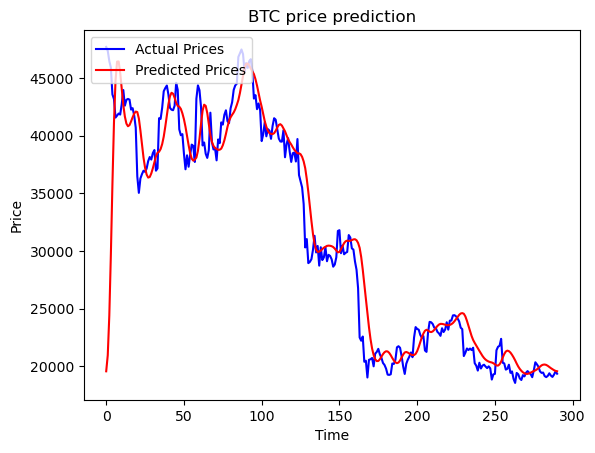

In [6]:
#test model
test_start= dt.datetime(2022,1,1)
test_end= dt.datetime.now()

test_data= web.DataReader(f'{cryto}-{currency}', 'yahoo', test_start, test_end)
actual_prices= test_data['Close'].values

total_dataset= pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs= total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs= model_inputs.reshape(-1,1)
model_inputs= scaler.fit_transform(model_inputs)

x_test= []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test= np.array(x_test)
x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#obtain prediction prices via .predict then inverse the prediction prices to obtain actual values
prediction_prices= model.predict(x_test)
prediction_prices= scaler.inverse_transform(prediction_prices)
#plot via matplotlib 
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(prediction_prices, color='red', label='Predicted Prices')
plt.title(f'{cryto} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()



In [9]:
#predict next day 
real_data= [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data= np.array(real_data)
real_data= np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction= model.predict(real_data)
prediction= scaler.inverse_transform(prediction)
prediction

1/1 [==============================] - 0s 23ms/step


array([[5.3105613e+09]], dtype=float32)

In [17]:
#test model
test_start= dt.datetime(2021,1,1)
test_end= dt.datetime(2022,1,1)

test_data= web.DataReader(f'{cryto}-{currency}', 'yahoo', test_start, test_end)
actual_prices= test_data['Close'].values

total_dataset= pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs= test_data[len(test_data) - prediction_days:].values
model_inputs= model_inputs.reshape(-1,1)
model_inputs= scaler.fit_transform(model_inputs)

x_test= []
y_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    y_test.append(model_inputs[x, 0])


x_test= np.array(x_test)
x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices= model.predict(x_test)

10/10 [==============================] - 0s 12ms/step


In [18]:
real_prices = scaler.inverse_transform(np.array(y_test).reshape(1,-1))

In [19]:
predicted_prices_raw = scaler.inverse_transform(prediction_prices)